In [1]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import random
from tqdm import tqdm

from collections import defaultdict, namedtuple

from IPython.display import clear_output

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 14) # (w, h)

In [2]:
from mtcnn.mtcnn import MTCNN
mtcnn = MTCNN()

from keras_facenet import FaceNet
embedder = FaceNet()
clear_output()

In [3]:
cache_file = 'cache.pickle'
metadata_filename = 'metadata.json'
events_path = os.path.join('data', 'CVDataset')

In [4]:
from utils import load_image, load_images, load_face_information, cache_face_information, load_image, cache_face_information, use_tqdm, ImageLoader

In [5]:
def encode_face(img):
    location = locate_faces(img)[:1]
    face_img = extract_faces(img, location)
    return embedder.embeddings(face_img)[0]

def encode_faces(img, locations):
    return embedder.embeddings(extract_faces(img, locations))

def extract_faces(img, locations):
    res_imgs = []
    for (y1, x1, y2, x2) in locations:
        res_imgs.append(img[y1:y2, x2:x1])
    return res_imgs

def draw_faces(img, locations, verbose=True, title=None):
    res_img = img.copy()
    for (y1, x1, y2, x2) in locations:
        cv2.rectangle(res_img, (x1, y2), (x2, y1), (0, 255, 0), 4)
    if verbose:
        plt.imshow(res_img)
        plt.title(title)
        plt.show()
    return res_img

def locate_faces(img):
    faces = mtcnn.detect_faces(img)
    faces = [x['box'] for x in faces]
    faces = [(max(y, 0),
              min(x+w, img.shape[1]),
              min(y+h, img.shape[0]),
              max(x, 0)) for x, y, w, h in faces]
    return np.array(faces)

def face_distance(face1, face2):
    return np.linalg.norm(face1 - face2, axis=1)

def compare_faces(face1, face2, tolerance=None):
    tolerance = tolerance or 0.9
    return list(face_distance(face1, face2) <= tolerance)

In [6]:
class Person:
    def __init__(self, img, name):
        self.img = img
        self.name = name
        self.encoding = encode_face(img).reshape(1, -1)

# Load photo with the person
person = Person(load_image(os.path.join('data', 'boris.jpg')), 'Boris')

# person = Person(load_image(os.path.join('data', 'ivan_2.jpg')), 'Ivan')

# person = Person(load_image(os.path.join('data', 'vlad.jpg')), 'Vlad')

# person = Person(load_image(os.path.join('data', 'denis.jpg')), 'Denis')

# person = Person(load_image(os.path.join('data', 'andrey.jpg')), 'Andrey')

# person = Person(load_image(os.path.join('data', 'andr_pav.jpg')), 'Andrey')

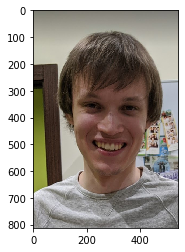

In [7]:
plt.imshow(person.img[:, :, ::-1])

In [8]:
# List folders
folders = glob.glob(os.path.join(events_path, '*'))
images = ImageLoader(os.path.join(events_path, '*'))
print(np.array(folders))

['data\\CVDataset\\Slippers of the Year 2019']


In [9]:
events_metadata = defaultdict(set)
for folder in folders:
    with open(os.path.join(folder, metadata_filename)) as metadata_file:
        event_metadata = json.loads(metadata_file.read())
    for k, v in event_metadata.items():
        events_metadata[k].update([os.path.join(folder, vi) for vi in v])
len(events_metadata)

3

In [10]:
def process_images(images, scale=0.5, desc="Processing faces in images"):
    """Get face locations and encodings from given images."""
    face_info = dict()
    for i, (img_name, img) in use_tqdm(enumerate(images),
                                       desc=desc,
                                       total=len(images)):
        # Scale down for faster processing
        small_img = cv2.resize(img, (0, 0), fx=scale, fy=scale)

        # Face detection
        face_locations = locate_faces(small_img)
        if len(face_locations) == 0:
            # Ignoring empty
            face_encodings = []
        else:
            # Face extraction
            face_encodings = encode_faces(small_img, face_locations)
        
        # Scale locations back
        face_locations = scale_locations(face_locations, 1 / scale)
        
        face_info[img_name] = {
            'locations': face_locations,
            'encodings': face_encodings
        }
    return face_info

def scale_locations(locations, scale=2):
    return (locations * scale).astype(int)
    for i, loc in enumerate(locations):
        for j, coord in enumerate(loc):
            locations[i, j] = int(coord * scale)
    return locations

face_info = defaultdict(dict)
for folder in folders:
    cache_path = os.path.join(folder, cache_file)
    if os.path.exists(cache_path):
        face_info[folder] = load_face_information(cache_path)
        print('Loaded cached data')
    else:
        face_info[folder] = process_images(ImageLoader(folder))
        cache_face_information(face_info[folder], cache_path)

Loaded cached data


In [11]:
def calc_stats(predicted, real):
    accuracy = len(real.intersection(predicted)) / len(real)
    recall = len(real.intersection(predicted)) / len(predicted)
    print(len(real.intersection(predicted)))
    return accuracy, recall

In [12]:
def find_images_with_person(face_encoding, face_information, tolerance=None):
    images_with_person = dict()
    for i, (img_name, face_info) in use_tqdm(enumerate(face_information.items()),
                                       desc=f'Finding images',
                                       total=len(face_information)):

        if len(face_info['locations']) == 0 or len(face_info['encodings']) == 0:
            continue

        matches = compare_faces(face_encoding, face_info['encodings'], tolerance)

        if any(matches):
            images_with_person[img_name] = face_info['locations'][matches]
    return images_with_person

results = dict()
person_locations = []
for folder in folders:
    results.update(find_images_with_person(person.encoding, face_info[folder]))
    
result_img_paths = list(map(os.path.normpath, results))
acc, recall = calc_stats(result_img_paths, events_metadata[person.name.lower()])

print(f"""Found {len(results)} images with {person.name}.
Accuracy: {acc:.3}
Recall:   {recall:4.3}
""")

Finding images: 100%|██████████████████████████████████████████| 440/440 [00:00<00:00, 36535.75it/s]


3
Found 4 images with Boris.
Accuracy: 0.429
Recall:   0.75



In [13]:
list(results.keys())[:10], len(results)

(['data/CVDataset\\Slippers of the Year 2019\\13.05 (140).jpg',
  'data/CVDataset\\Slippers of the Year 2019\\13.05 (142).jpg',
  'data/CVDataset\\Slippers of the Year 2019\\13.05 (143).jpg',
  'data/CVDataset\\Slippers of the Year 2019\\13.05 (147).jpg'],
 4)

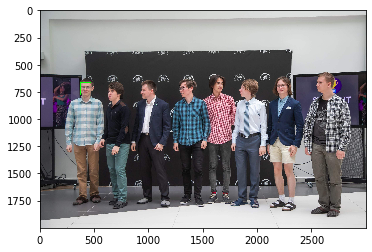

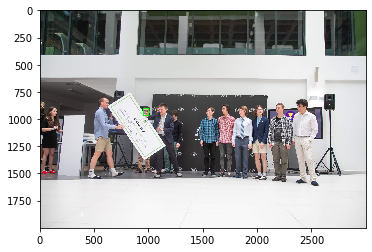

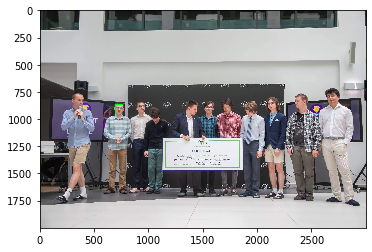

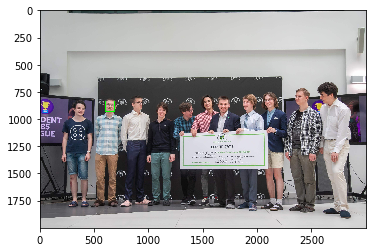

In [14]:
for img_path, locs in list(results.items())[:6]:
    img = load_image(img_path)[:, :, ::-1]
    draw_faces(img, locs)

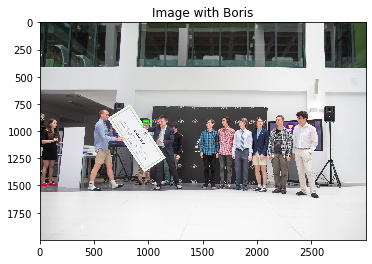

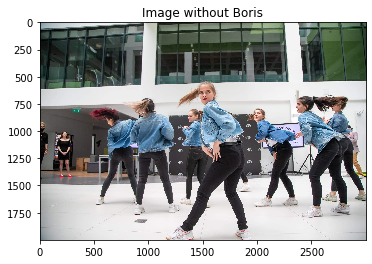

In [15]:
if len(results) > 0:
    image_path, face_loc = random.choice(list(results.items()))
    img = load_image(image_path)[:, :, ::-1]
    draw_faces(img, face_loc, title=f'Image with {person.name}')
else:
    print('No images with', person.name)


if len(results) != len(images.image_paths):
    image_path = random.choice(images.image_paths)
    while image_path in results.keys():
        image_path = random.choice(images.image_paths)
    plt.imshow(load_image(image_path)[:, :, ::-1])
    plt.title(f'Image without {person.name}')
    plt.show()
else:
    print('No images without', person.name)